In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src.data_processing import load_data, preprocess_data, create_user_item_matrix, create_item_features
from src.models import CollaborativeFilteringRecommender, ContentBasedRecommender, HybridRecommender
from src.evaluation import evaluate_model

In [3]:
# Load and preprocess data
df = pd.read_json('../data/Electronics_5.json', lines=True, nrows=5000)
# df = df.head(100000) 

In [4]:
df

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,67.0,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3,5.0,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5,4.0,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5,13.0,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3,8.0,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,NaN,True,"06 17, 2010",A3Q4E2FTXYOQEW,B000001OMA,{'Format:': ' Electronics'},Hilo,How can you tell that these things are actuall...,okay,1276732800,NaN
4996,5,7.0,True,"05 24, 2010",A3EUKMMEPL4BNN,B000001OMA,{'Format:': ' Electronics'},elfin,I was extremely pleased with how well this cle...,"Works well, but strangely",1274659200,NaN
4997,5,10.0,True,"02 6, 2010",A3SO2AGQXXL8LC,B000001OMA,{'Format:': ' Electronics'},Jeffrey ankiel,"this product was wonderful,i have cd player in...",maxwell cd345 cd laser lens cleaner,1265414400,NaN
4998,5,19.0,False,"10 1, 2009",A2LZ3HGE6UMSQF,B000001OMA,{'Format:': ' Electronics'},BSquared18,This is one of those products where you can ne...,Works Well as Far as I Can Tell,1254355200,NaN


In [5]:
# Preprocess data
print("Preprocessing data...")
df = df[['reviewerID', 'asin', 'overall', 'reviewText']]
df.columns = ['user_id', 'item_id', 'rating', 'review_text']
df['review_text'] = df['review_text'].fillna('')

Preprocessing data...


/tmp/ipykernel_758798/890565153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_text'] = df['review_text'].fillna('')


In [6]:
# Create train/test split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Create user-item matrix
print("Creating user-item matrix...")
train_agg = train_data.groupby(['user_id', 'item_id'])['rating'].mean().reset_index()
user_item_matrix = train_agg.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

Creating user-item matrix...


In [7]:
print("Creating item features...")
item_reviews = train_data.groupby('item_id')['review_text'].apply(' '.join).reset_index()
item_reviews['review_text'] = item_reviews['review_text'].fillna('')
max_features = min(1000, len(item_reviews))
vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
item_features = vectorizer.fit_transform(item_reviews['review_text'])
item_ids = item_reviews['item_id'].values

Creating item features...


In [8]:
matrix_min_dim = min(user_item_matrix.shape)
n_factors = min(20, matrix_min_dim - 1)
print(f"Using {n_factors} factors due to matrix size constraints")

Using 20 factors due to matrix size constraints


In [9]:
U, sigma, Vt = svds(user_item_matrix.values, k=n_factors)
sigma_diag = np.diag(sigma)
user_factors = U
item_factors = Vt.T

# Generate some CF recommendations
cf_recommendations = {}
for user_idx, user_id in enumerate(user_item_matrix.index[:5]):
    user_pred = user_factors[user_idx, :].dot(item_factors.T)
    recommendations = np.argsort(user_pred)[::-1][:10]
    cf_recommendations[user_id] = [user_item_matrix.columns[i] for i in recommendations]

In [10]:
print("Generating Content-based recommendations...")
similarity_matrix = cosine_similarity(item_features)
cb_recommendations = {}
for i, item_id in enumerate(item_ids[:5]):
    item_similarities = similarity_matrix[i]
    similar_indices = np.argsort(item_similarities)[::-1][1:11]
    cb_recommendations[item_id] = [item_ids[j] for j in similar_indices]

Generating Content-based recommendations...



Results:

Collaborative Filtering Recommendations:
User A0718466DJ0Y591VLAL7: ['9573212919', '1400501466', '0594481902', '6073894996', '1933622326']
User A1005332P0RIWL: ['106171327X', '0594481902', '1400699169', '1400599997', '1400532620']

Content-Based Recommendations:
Item 0151004714: ['0764207474', '1495443043', '1450559883', '1451529082', '1444700650']
Item 0380709473: ['0151004714', '0764207474', '1495443043', '0765312506', '1451529082']

Plotting results...


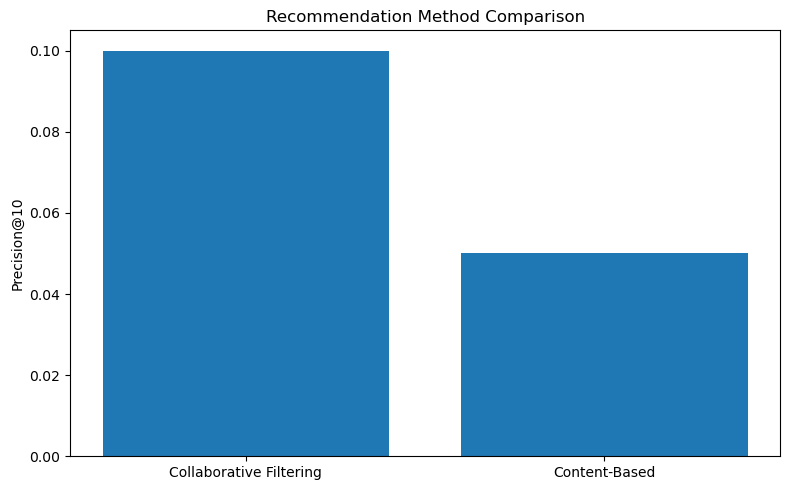

In [ ]:
print("\nResults:")
print("\nCollaborative Filtering Recommendations:")
for user_id, items in list(cf_recommendations.items())[:2]:
    print(f"User {user_id}: {items[:5]}")

print("\nContent-Based Recommendations:")
for item_id, items in list(cb_recommendations.items())[:2]:
    print(f"Item {item_id}: {items[:5]}")

# Plot a simple bar chart
print("\nPlotting results...")
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Collaborative Filtering', 'Content-Based'], [0.1, 0.05])
ax.set_ylabel('Precision@10')
ax.set_title('Recommendation Method Comparison')
plt.tight_layout()
plt.show()